# Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [10]:
import os
import sys
import itertools
import math
import scipy
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from PIL import Image

# Local modules
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

%matplotlib inline 

# Project root directory
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

DATASET_DIR = os.path.join(ROOT_DIR, "datasets", "defects_1_processed_renamed")

C:\Users\jun\OneDrive\work\tensorFlow\project\casting_defect_localization_dicastal


In [31]:
# Local modules
from config import Config

# Class ID
BACKGROUND = 0
CASTING_DEFECT = 1

class TrainConfig(Config):
    """Configuration for training on Dicastal's X-ray Dataset
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    For more details, go to Config.py
    """
    # Give the configuration a recognizable name
    NAME = "dicastalxray"

    # We use a GPU with 11 GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    # updates are saved at the end of each epoch, so setting this to a
    # smaller number means getting more frequent TensorBoard updates.
    # Validation stats are also calculated at each epoch end and they
    # might take a while, so don't set this too small to avoid spending
    # a lot of time on validation stats.
    STEPS_PER_EPOCH = 1000

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 50

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # For now, 1 background + 1 defect

    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 768

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 50

    # Non-max suppression threshold to filter RPN proposals.
    # You can reduce this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.5

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

class XrayDataset(utils.Dataset):
    """
    Dataset of Xray Images

    Images are referred to using their image_id (relative path to image).
    An example image_id is: ""
    """

    def load_dicastalxray(self, dataset_dir, subset):
        """Load a subset of the dicastal X-ray dataset.
        dataset_dir: The root directory of the dicastal X-ray dataset.
        subset: What to load (train, validation)
        """
        castings_metadata = "datasets/annotation_filenames_{0}.csv".format(subset)
        metadata = [castings_metadata]
        # print(metadata)
        image_ids = []
        for metadata_path in metadata:
            with open(metadata_path,"r") as metadata_file:
                image_ids += metadata_file.readlines()
        # Strip all the newlines
        image_ids = [p.rstrip() for p in image_ids]
        #print(image_ids)
        
        # Add classes
        self.add_class(source="dicastalxray", class_id=CASTING_DEFECT, class_name="Pore")

        # Add images
        for image_id in image_ids:
            path = os.path.join(dataset_dir, "images", image_id)
            im = Image.open(path)
            width, height = im.size

            if not os.path.exists(self.get_mask_path(dataset_dir, image_id, 0)):
                print("Skipping ",image_id," Reason: No mask")
                continue

            print("Adding image:", image_id)

            self.add_image(
                "dicastalxray",
                image_id=image_id,
                path=path,
                width=width,
                height=height,
                dataset_dir=dataset_dir,
                # annotations=???
            )
            # self.create_mask(dataset_dir,image_id)

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        masks = []
        info = self.image_info[image_id]
        image_id = info["id"]
        dataset_dir = info["dataset_dir"]

        for i in range(100):
            path = self.get_mask_path(dataset_dir, image_id, i)
            if os.path.exists(path):
                mask = scipy.ndimage.imread(path)
                mask = mask.astype(np.bool)
                masks.append(mask)
                # Debugging
                #import matplotlib.pyplot as plt
                #image = scipy.ndimage.imread(info["path"])
                #plt.figure()
                #plt.imshow(image)
                #plt.figure()
                #plt.imshow(mask)
                #plt.show()
            else:
                break
        mask = np.stack(masks,axis=-1)

        # Get defect type
        CLASS = CASTING_DEFECT
        class_ids = np.array([CLASS for _ in range(len(masks))], dtype=np.int32)

        return mask, class_ids


    def get_mask_path(self, dataset_dir, image_id, index):
        """Return the path to a mask"""
        mask_dir = os.path.join(dataset_dir, "masks")
        mask_name = image_id.replace(".bmp","_%i.png"%index)
        mask_path = os.path.join(mask_dir, mask_name)
        # print(image_id, mask_name)
        return mask_path


    def image_reference(self, image_id):
        """Return a link to the image in the COCO Website."""
        info = self.image_info[image_id]
        if info["source"] == "coco":
            return "http://cocodataset.org/#explore?id={}".format(info["id"])
        else:
            super(self.__class__).image_reference(self, image_id)

## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [32]:
# Run one of the code blocks
#import coco
config = TrainConfig()

## Dataset

## Display Samples

Load and display images and masks.

In [33]:
# Load dataset
dataset = XrayDataset()
dataset.load_dicastalxray(DATASET_DIR, "train")
    
# Must call before using the dataset
dataset.prepare()

#print("Image Count: {}".format(len(dataset.image_ids)))
#print("Class Count: {}".format(dataset.num_classes))
#for i, info in enumerate(dataset.class_info):
    #print("{:3}. {:50}".format(i, info['name']))

Adding image: 0.bmp
Adding image: 1.bmp
Adding image: 2.bmp
Adding image: 3.bmp
Adding image: 5.bmp
Adding image: 6.bmp
Adding image: 8.bmp
Adding image: 9.bmp
Adding image: 11.bmp
Adding image: 12.bmp
Adding image: 14.bmp
Adding image: 16.bmp
Adding image: 18.bmp
Adding image: 20.bmp
Adding image: 21.bmp
Adding image: 22.bmp
Adding image: 23.bmp
Adding image: 24.bmp
Adding image: 25.bmp
Adding image: 26.bmp
Adding image: 27.bmp
Adding image: 28.bmp
Adding image: 29.bmp
Adding image: 30.bmp
Adding image: 31.bmp
Adding image: 32.bmp
Adding image: 33.bmp
Adding image: 34.bmp
Adding image: 35.bmp
Adding image: 36.bmp
Adding image: 37.bmp
Adding image: 38.bmp
Adding image: 39.bmp
Adding image: 40.bmp
Adding image: 41.bmp
Adding image: 43.bmp
Adding image: 42.bmp
Adding image: 44.bmp
Adding image: 45.bmp
Adding image: 46.bmp
Adding image: 47.bmp
Adding image: 48.bmp
Adding image: 49.bmp
Adding image: 50.bmp
Adding image: 51.bmp
Adding image: 52.bmp
Adding image: 53.bmp
Adding image: 54.bmp


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


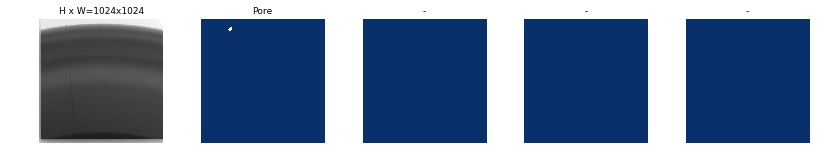

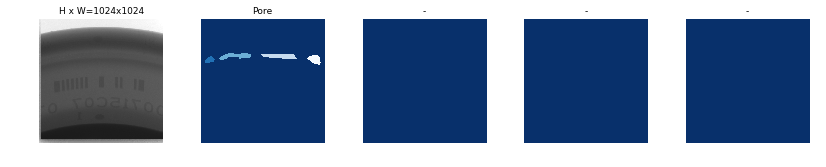

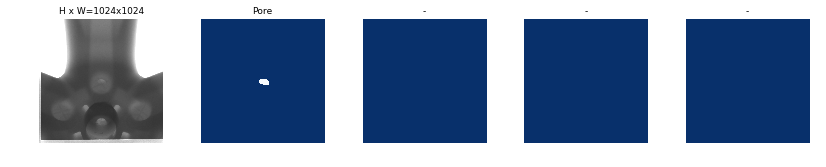

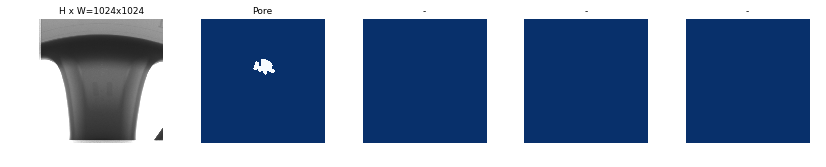

In [34]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
mask                     shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000
class_ids                shape: (7,)                  min:    1.00000  max:    1.00000
bbox                     shape: (7, 4)                min:   67.00000  max:  670.00000


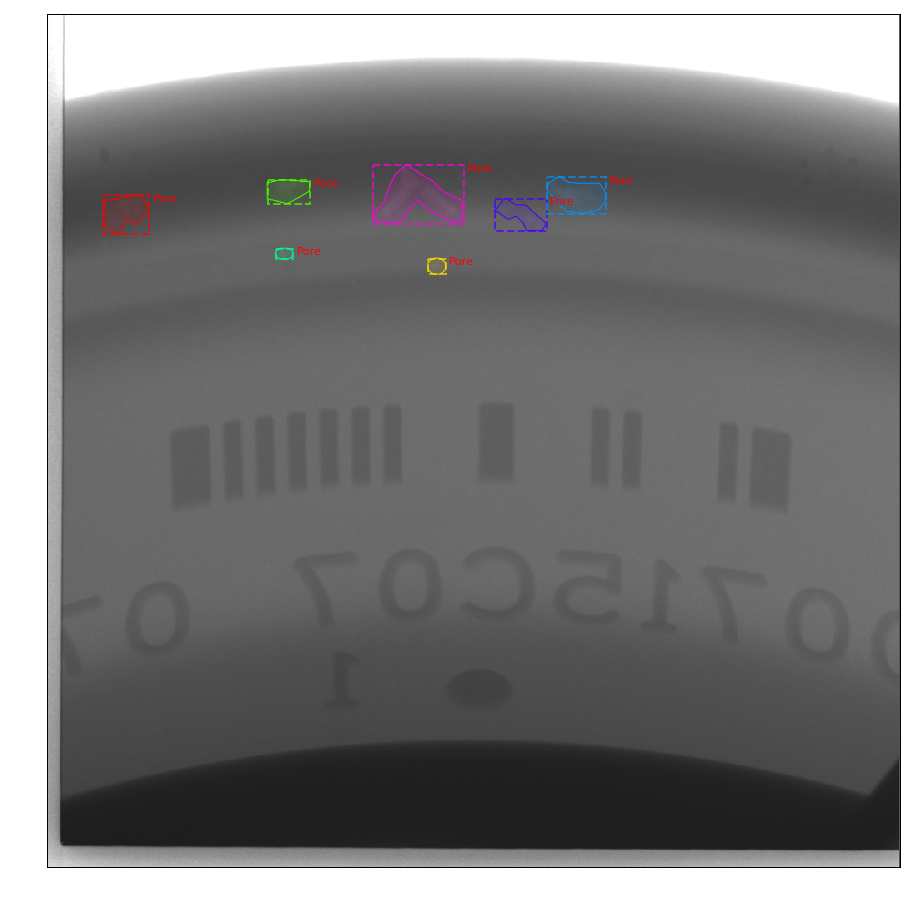

In [37]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
#print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Original shape:  (1024, 1024, 3)
image                    shape: (768, 768, 3)         min:   13.00000  max:  255.00000
mask                     shape: (768, 768, 1)         min:    0.00000  max:    1.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
bbox                     shape: (1, 4)                min:  341.00000  max:  681.00000


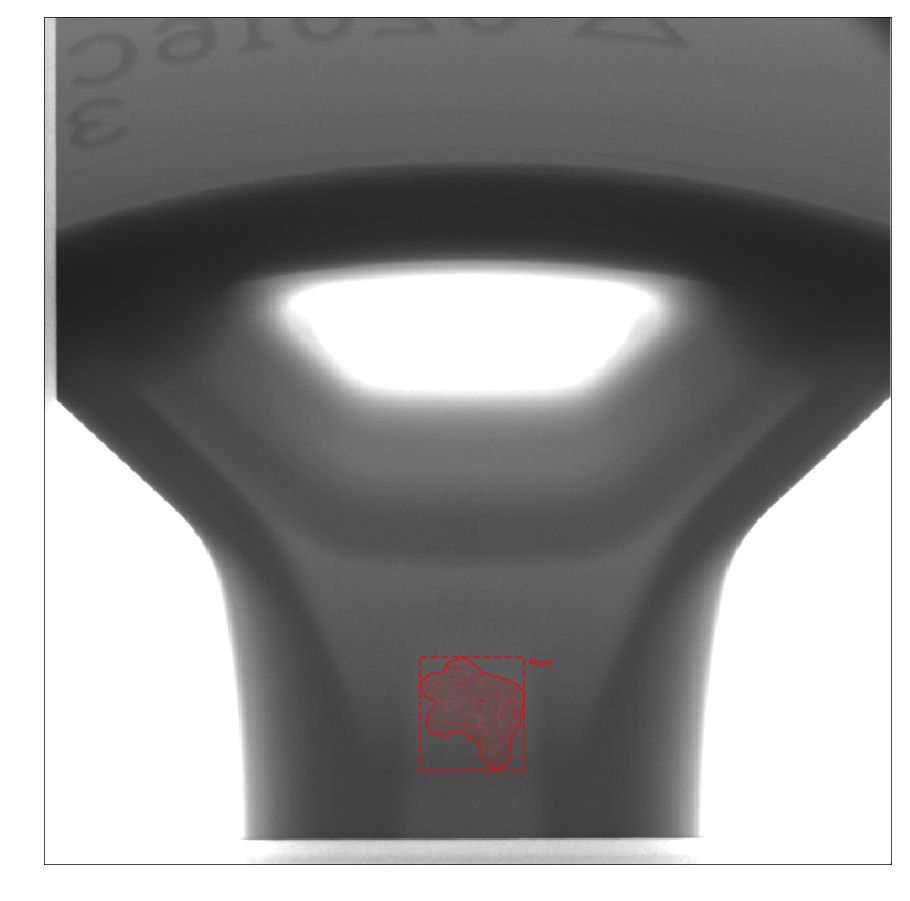

In [40]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    padding=config.IMAGE_PADDING)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
# print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (768, 768, 3)         min:   12.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
bbox                     shape: (1, 4)                min:   82.00000  max:  681.00000
mask                     shape: (768, 768, 1)         min:    0.00000  max:    1.00000


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


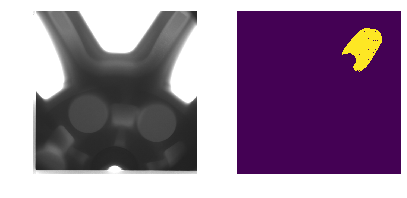

In [41]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

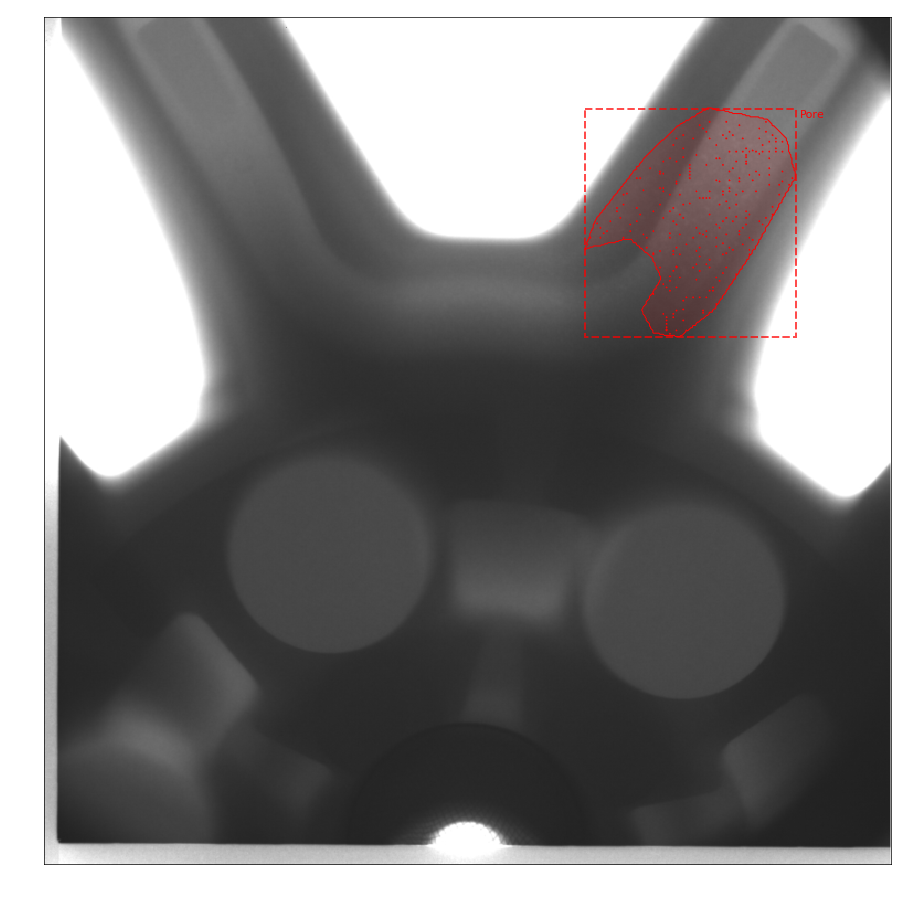

In [42]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (128, 128, 1)         min:    0.00000  max:    1.00000


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


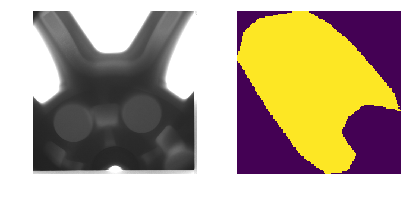

In [43]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

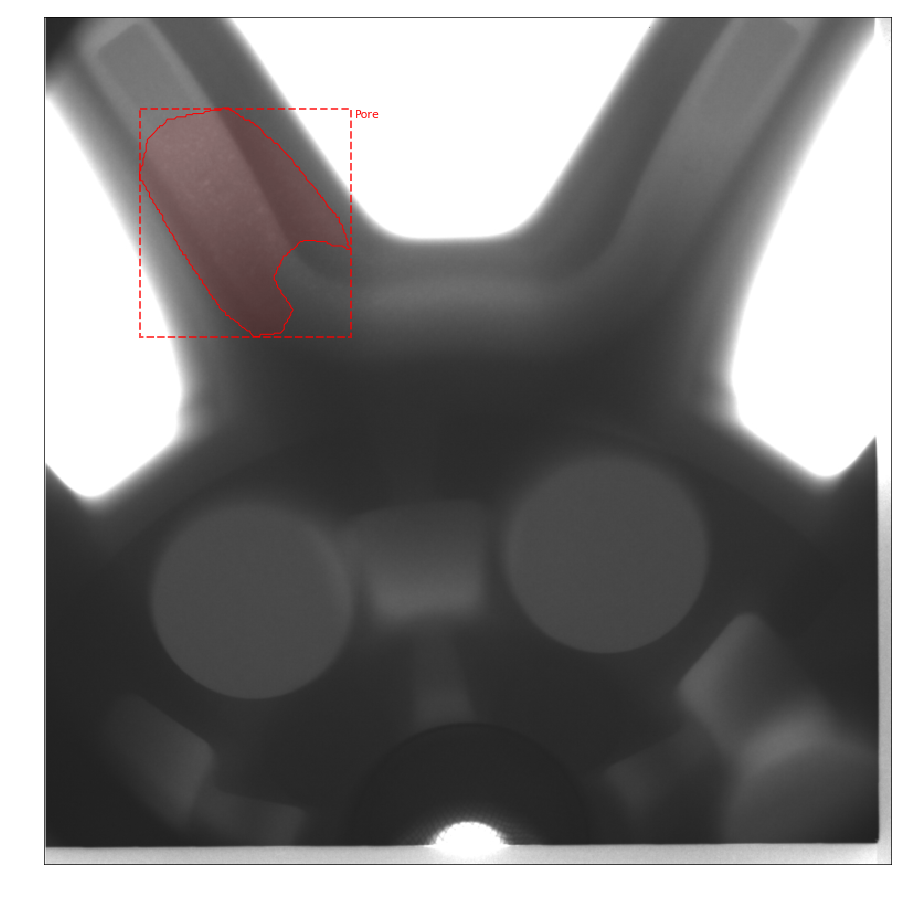

In [44]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [45]:
# Generate Anchors
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          config.BACKBONE_SHAPES,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(config.BACKBONE_SHAPES)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = config.BACKBONE_SHAPES[l][0] * config.BACKBONE_SHAPES[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  147312
Scales:  (16, 32, 64, 128, 256)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 110592
Anchors in Level 1: 27648
Anchors in Level 2: 6912
Anchors in Level 3: 1728
Anchors in Level 4: 432


Visualize anchors of one cell at the center of the feature map of a specific level.

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Level 0. Anchors: 110592  Feature map Shape: [192 192]
Level 1. Anchors:  27648  Feature map Shape: [96 96]
Level 2. Anchors:   6912  Feature map Shape: [48 48]
Level 3. Anchors:   1728  Feature map Shape: [24 24]
Level 4. Anchors:    432  Feature map Shape: [12 12]


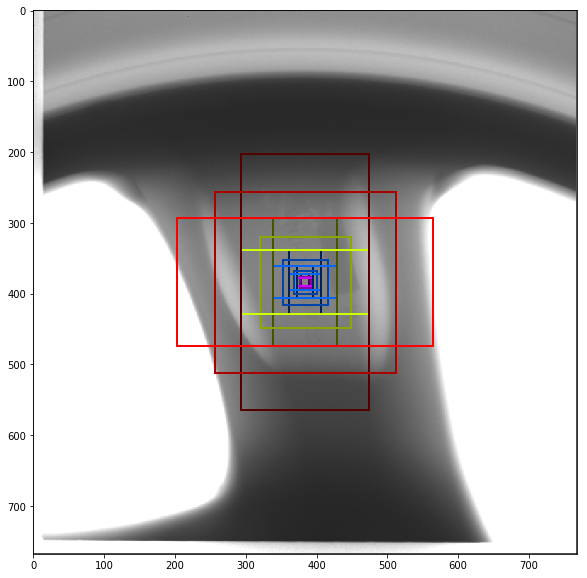

In [46]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(config.BACKBONE_SHAPES)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                config.BACKBONE_SHAPES[level]))
    center_cell = config.BACKBONE_SHAPES[level] // 2
    center_cell_index = (center_cell[0] * config.BACKBONE_SHAPES[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * config.BACKBONE_SHAPES[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [47]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [30]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [49]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = image_meta[0][0]
# print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


rois                     shape: (4, 50, 4)            min:    0.00000  max:  766.00000
mrcnn_class_ids          shape: (4, 50, 1)            min:    0.00000  max:    1.00000
mrcnn_bbox               shape: (4, 50, 2, 4)         min:   -3.20152  max:    3.48485
mrcnn_mask               shape: (4, 50, 28, 28, 2)    min:    0.00000  max:    1.00000
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  763.00000
gt_masks                 shape: (4, 128, 128, 100)    min:    0.00000  max:    1.00000
rpn_match                shape: (4, 147312, 1)        min:   -1.00000  max:    1.00000
rpn_bbox                 shape: (4, 256, 4)           min:   -2.49062  max:    3.67364


anchors                  shape: (147312, 4)           min: -181.01934  max:  885.01934
refined_anchors          shape: (1, 4)                min:  568.00000  max:  650.00000
Positive anchors: 1
Negative anchors: 255
Neutral anchors: 147056
BG                     : 34
Pore                   : 16


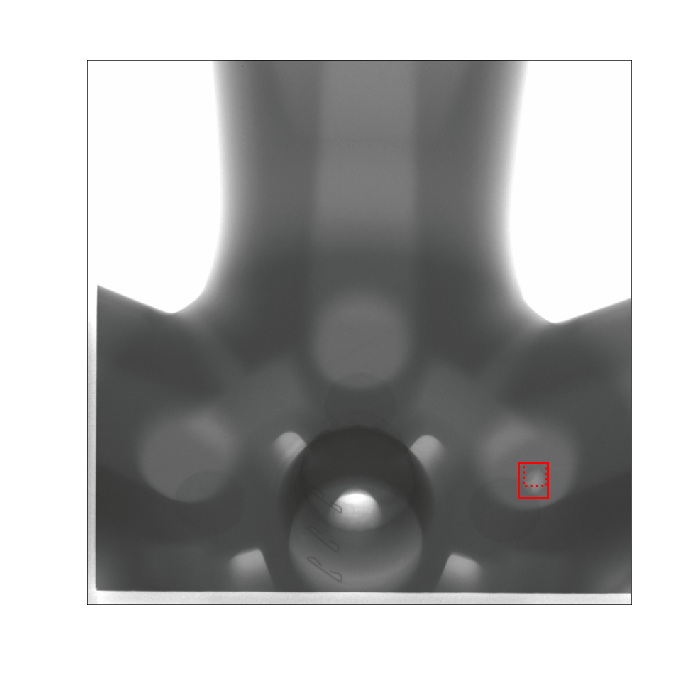

In [50]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

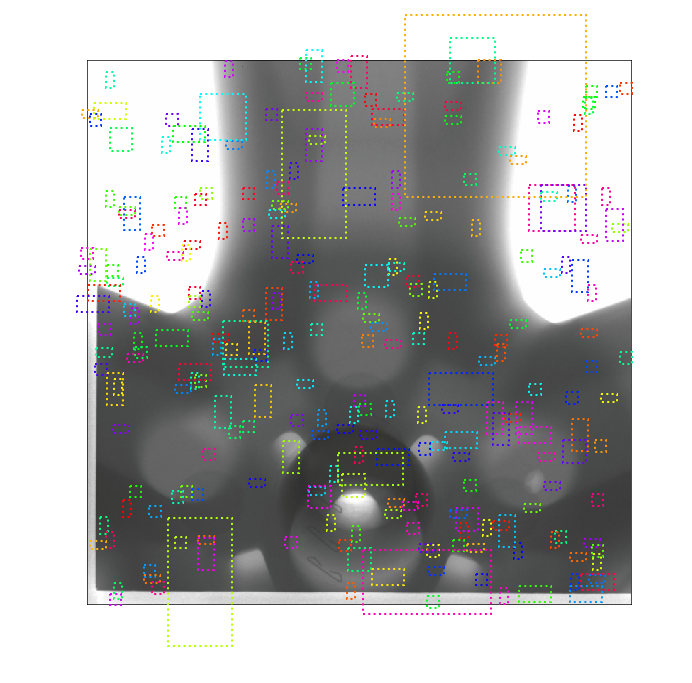

In [51]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

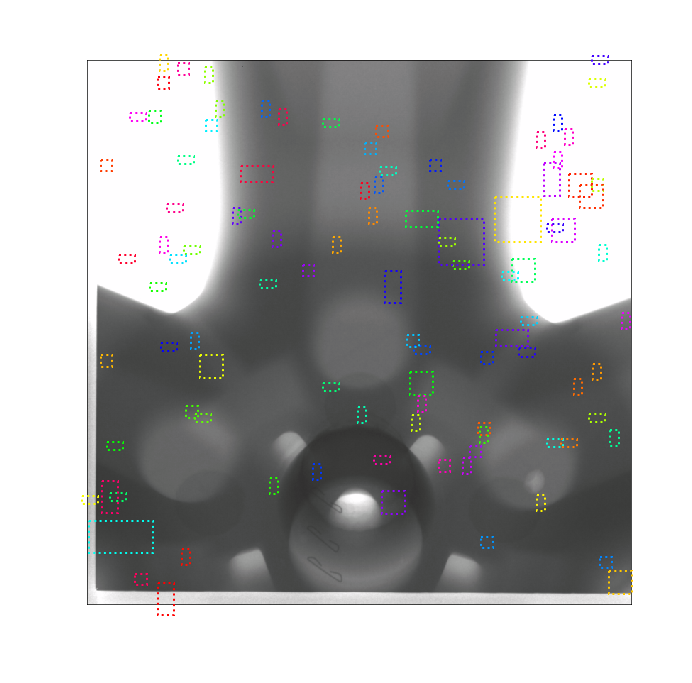

In [52]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  16
Negative ROIs:  34
Positive Ratio: 0.32
Unique ROIs: 50 out of 50


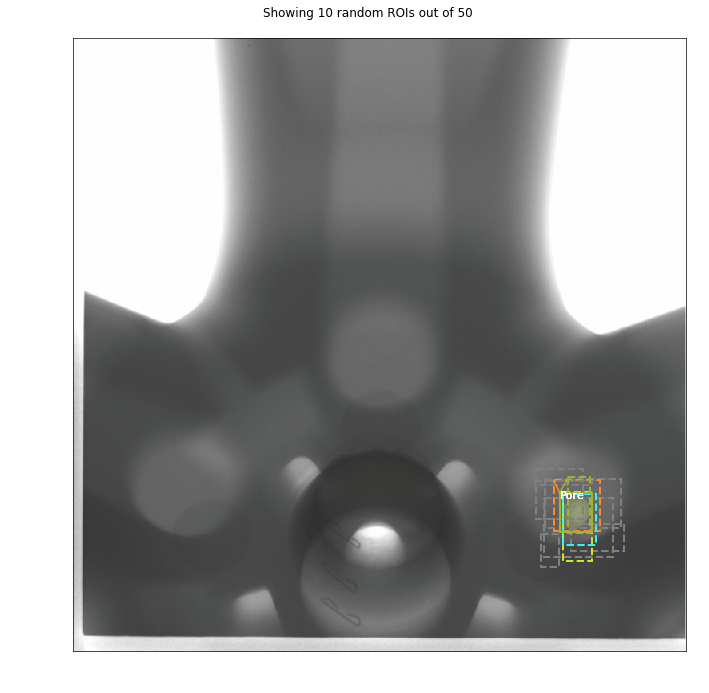

In [53]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

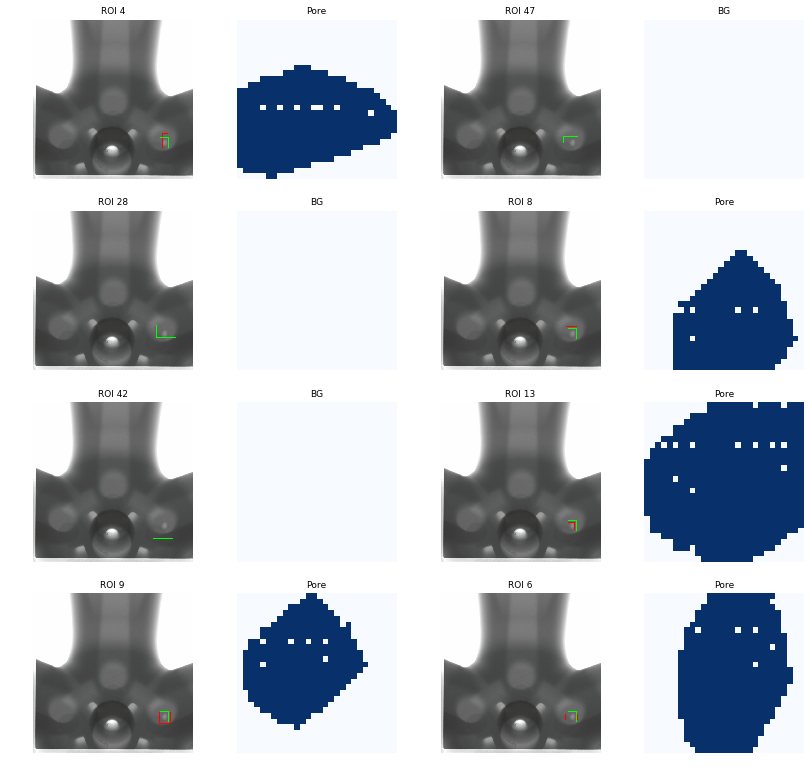

In [54]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [55]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
Average percent: 0.32
